In [1]:
import sys
sys.path.insert(0, "../../core/")

from os.path import join
from collections import namedtuple
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pickle import load
from scipy.stats import chi2

# PLEnuM tools
import settings as st
from tools import get_mids
# from fluxes import ngc_flux, ngc_cut_flux, PL_flux, PLcut_flux, power_law, cut_off
from aeff_calculations import get_aeff_and_binnings

# plot settings
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# plt.style.use("../../style.mplstyle")

plot_path = "plots/ngc_paper"

# Time evolution

## Point-source discovery potential --- breakdown

In [2]:
flux_psd = pd.read_csv(
    "../../resources/point-source_discovery_time-evolution.csv"
)

In [3]:
colors_detectors = {
    'IceCube': '#D8F3DC',
    'IceCube-Gen2': '#52B788',
    'KM3NeT': '#B7E4C7',
    'Baikal-FVD': '#95D5B2',
    'P-ONE': '#74C69D',
    'NEON': '#4BAA7F',
    'TRIDENT': '#4BAA7F',
    'HUNT': '#4BAA7F',
}

In [4]:
icecube_ref_time = st.LIVETIME_DAYS / 365  # approx. 9.7 Years of full detector (NGC 1068 analysis)

start_dates = [
    {"label": r"IceCube (IC)", "detector": "IceCube", "Year": 2020-icecube_ref_time, "colors": colors_detectors['IceCube'], "end": 2035},
    {"label": r"IceCube", "detector": "IceCube extrapolated", "Year": 2020-icecube_ref_time, "colors": "0.8", "end": 2060}, ## WIP
    {"label": r"+ KM3NeT (1 IC)", "detector": "KM3NeT", "Year": 2025, "colors": colors_detectors['KM3NeT'], "end": 2060},
    {"label": r"+ Baikal-GVD (1 IC)", "detector": "Baikal-GVD", "Year": 2028, "colors": colors_detectors['Baikal-FVD'], "end": 2060},
    {"label": r"+ P-ONE (1 IC)", "detector": "P-ONE", "Year": 2031, "colors": colors_detectors['P-ONE'], "end": 2060},
    {"label": r"+ IceCube-Gen2 (7.5~IC)", "detector": "Gen-2", "Year": 2035, "colors": colors_detectors['IceCube-Gen2'], "end": 2060},
    {"label": r"+ NEON (2.5 IC)", "detector": "NEON", "Year": 2040, "colors": colors_detectors['NEON'], "end": 2060},
    {"label": r"+ TRIDENT (7.5 IC)", "detector": "TRIDENT", "Year": 2040, "colors": colors_detectors['TRIDENT'], "end": 2060},
    {"label": r"+ HUNT (30 IC)", "detector": "HUNT", "Year": 2040, "colors": colors_detectors['HUNT'], "end": 2060},
]
start_dates = pd.DataFrame(start_dates)
start_dates = start_dates.set_index("detector")
yr_max = 2050
Years = np.arange(2020, yr_max)

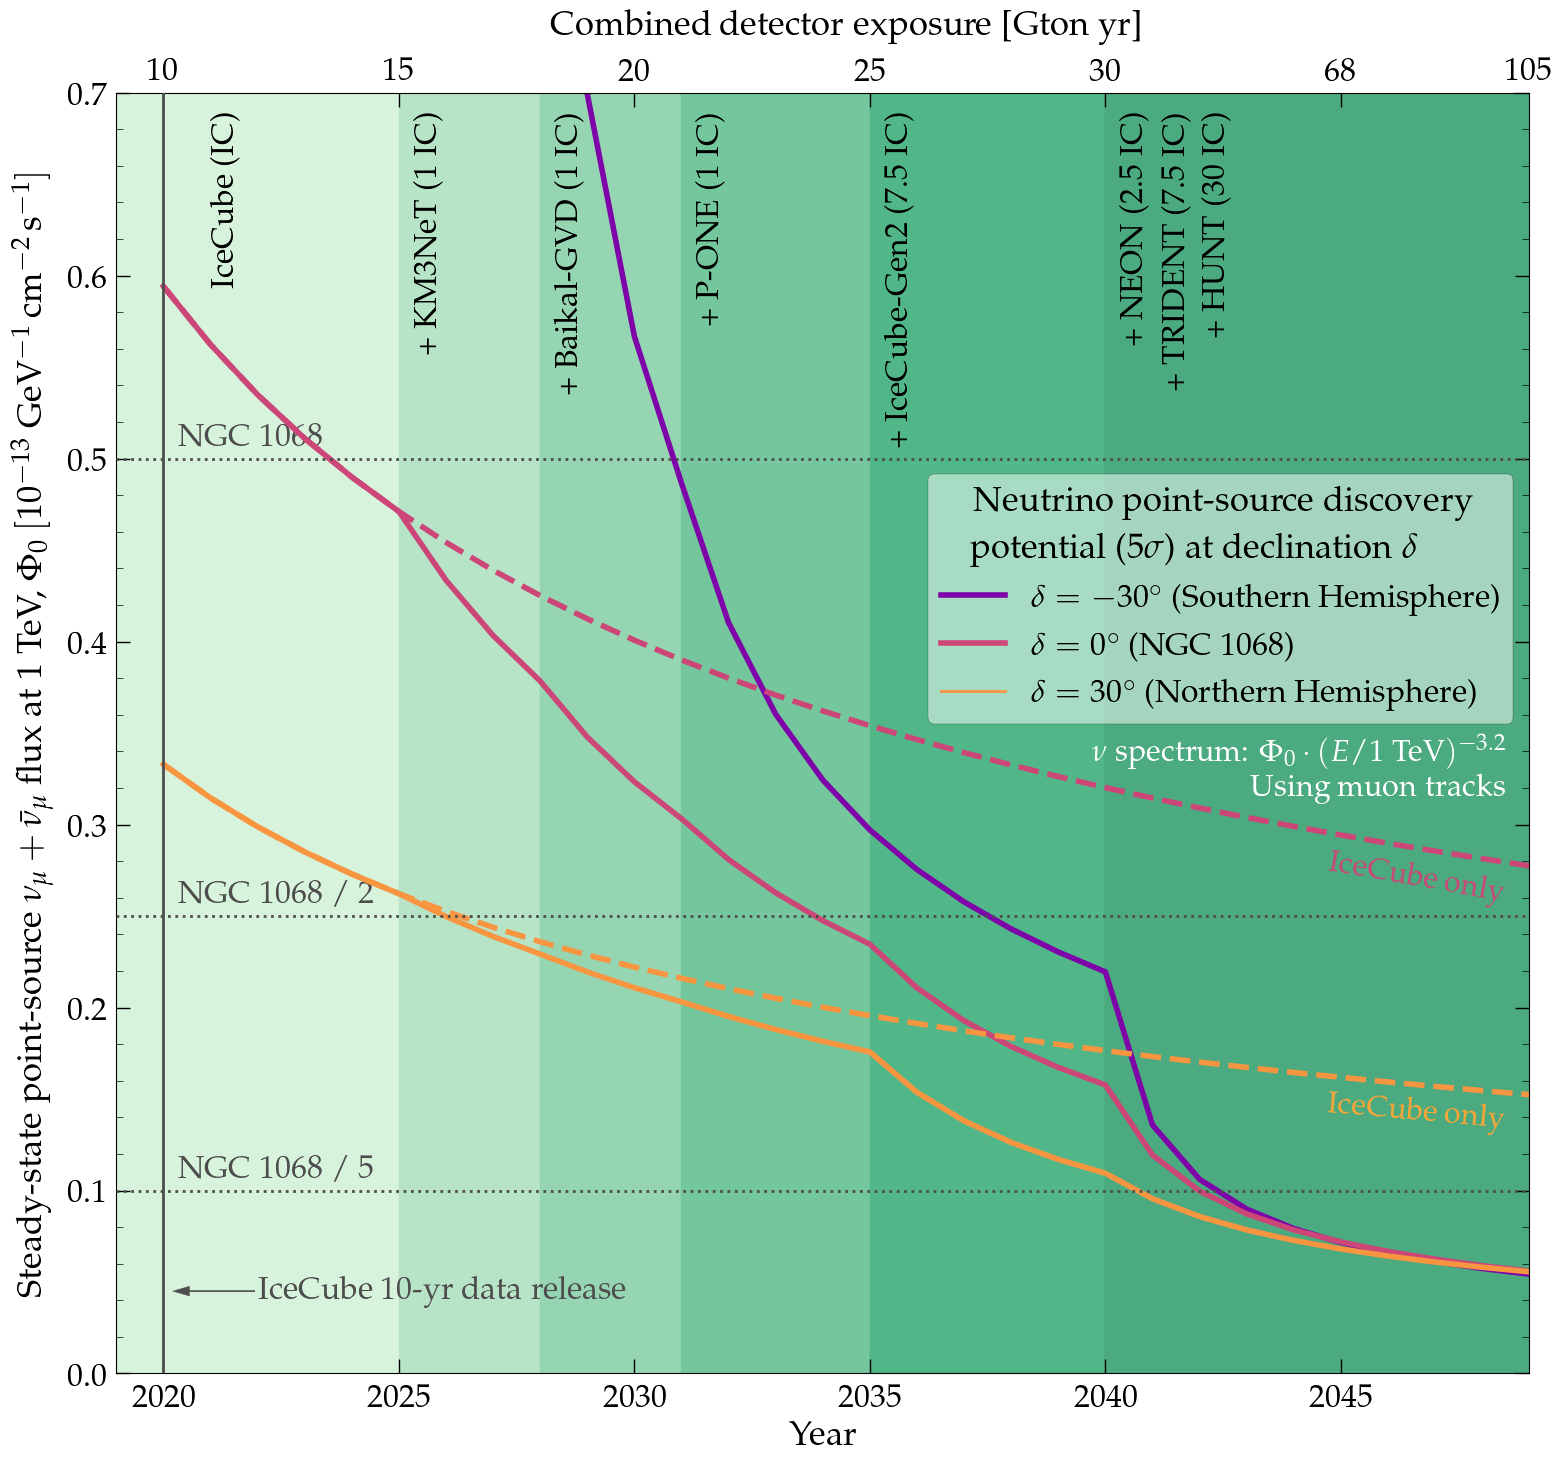

In [13]:
f, ax = plt.subplots(figsize=(18, 15.5)) #22
# f, ax = plt.subplots(figsize=(6, 5))

edge = 1
ax.set_ylim(0, edge)
width = 0.5e-1  # 0.6e-1
font_color = "0.3"
sigma_ref = 5
ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "IceCube 10-yr data release",
    (2020.2, 0.045),
    (2022, 0.045),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize=23,  # "large",
)
ax.annotate(
    r"$\nu$ spectrum: $\Phi_0 \cdot (E/{\rm 1~TeV})^{-3.2}$"
    + "\n Using muon tracks",
    xy=(2048.5, 0.35),
    ha="right",
    va="top",
    zorder=10,
    color='w',
    fontsize=22,  # "large",
)

ax.annotate(
    r'IceCube only',
    xy=(2048.5, 0.287),
    ha="right",
    va="top",
    zorder=10,
    color=matplotlib.colormaps['plasma'](0.5),
    fontsize=22, 
    rotation=-10.
)
ax.annotate(
    r'IceCube only',
    xy=(2048.5, 0.155),
    ha="right",
    va="top",
    zorder=10,
    color=matplotlib.colormaps['plasma'](0.8),
    fontsize=22, 
    rotation=-5.
)


for yr_i, series in start_dates.iterrows():
    if "extrapolated" in yr_i:
        continue
    if not "Gen" in yr_i:
        edge -= width
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.fill_between(
        x=[series.Year, yr_max], 
        y1=[1.0, 1.0],
        y2=0.0,
        color=series.colors,
        zorder=0.3
    )
    if yr_i == "IceCube":
        x = 2021
    elif yr_i == "TRIDENT":
        x = series.Year + 1.2
    elif yr_i == "HUNT":
        x = series.Year + 2.05
    else:
        x = series.Year + 0.3        
    ax.text(
        # x=series.Year + 0.3 if yr_i != "IceCube" else 2021,
        x=x,
        y=0.69,
        s=series.label,
        ha="left",
        va="top",
        fontsize=23,  # "x-large",
        zorder=2,
        rotation=90
    )
    
# plenum evolution
ax = sns.lineplot(
    data=flux_psd.loc[
        (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "PLEnuM")
    ],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    lw=4,
    legend=False,
    palette="plasma",
    dashes=False,
)
# icecube-only extrapolated
ax = sns.lineplot(
    data=flux_psd.loc[
        (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "IceCube extrapolated")
    ],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    units="dec",
    lw=4,
    ls="--",
    legend=False,
    palette="plasma",
)


# # plenum evolution markers
# selection = flux_psd.loc[
#     (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "PLEnuM")
# ]
# selection = selection.loc[(selection.Year < 2041) & (selection.Year % 5 == 0)]
# ax = sns.scatterplot(
#     data=selection,
#     x="Year",
#     y="scaled_flux",
#     hue="dec_label",
#     hue_order=["-30°", "0°", "30°"],
#     style="dec_label",
#     markers=["X", "s", "o"],
#     s=12**2,
#     palette="plasma",
#     ax=ax,
#     legend=False,
#     zorder=11,
# )
# extra plotting for legend
selection = flux_psd.loc[
    (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "PLEnuM")
]
selection = selection.loc[selection.Year == 2035]
ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=[
        r"$\delta = -30^\circ$~(Southern Hemisphere)",
        r"$\delta = 0^\circ$~(NGC 1068)",
        r"$\delta = 30^\circ$~(Northern Hemisphere)",
    ],
    style_order=[
        r"$\delta = -30^\circ$~(Southern Hemisphere)",
        r"$\delta = 0^\circ$~(NGC 1068)",
        r"$\delta = 30^\circ$~(Northern Hemisphere)",
    ],
    style="dec_label",
    units="dec",
    lw=4,
    ms=12,
    palette="plasma",
    # markers=["o", "X", "s"],
    dashes=False,
)
# IceCube extrapolated for legend
# plt.plot([-1, -3], [-1, -3], ls="--", lw=4, color="gray", label="IceCube only")

legend = ax.legend(
    bbox_to_anchor=(1.0, 0.715),
    # bbox_to_anchor=(1.0, 0.75),
    framealpha=0.5,
    loc=1,
    title=r"\hspace*{-0.5em}Neutrino point-source discovery\\[0.3em] potential ($5\sigma$) at declination $\delta$",
    ncol=1,
    fontsize=23,
    edgecolor="k",
    title_fontsize=25
)
# plt.setp(legend.get_title(), fontsize=18)  # "x-large")
for line in legend.get_lines()[:-1]:
    line.set_linewidth(4)
    line.set_markersize(12)

# Top x-axis (artificial, for simplicity)
volume_ic = 1.0  # IceCube volume [Gton]
ic_start = 2010  # 2011


### UPDATE -- I think this was not right in the first place 
# ... it does not count the Northern detectors? Or do I see this wrong?
def exposure_combined(year):
    if year <= 2025:
        exposure = volume_ic * (year - ic_start)
    elif 2025 < year <= 2030:
        exposure = exposure_combined(2025) + (year - 2025) * volume_ic
    elif 2030 < year <= 2035:
        exposure = exposure_combined(2030) + (year - 2030) * volume_ic
    elif 2035 < year <= 2040:
        exposure = exposure_combined(2035) + (year - 2035) * volume_ic
    elif year > 2040:
        exposure = exposure_combined(2040) + (year - 2040) * 7.5 * volume_ic
    return exposure


for year in np.linspace(2020, 2050, 7):
    ax.text(
        x=year if year<yr_max else yr_max-1,
        y=0.707,
        s="{:0.0f}".format(exposure_combined(year)),
        fontsize=23,
        ha="center",
    )
ax.text(
    x=2034.5, y=0.732, s="Combined detector exposure [Gton~yr]", fontsize=25, ha="center"
)

ax.set_xlim(2019, yr_max - 1)
ax.set_ylim(0, 0.7)
ax.set_xlabel(r"Year", fontsize=25)
ax.set_ylabel(
    r"Steady-state point-source $\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV, $\Phi_{0} ~ [10^{-13}~\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=25,
    labelpad=10
)
plt.yticks(fontsize=23)
plt.xticks(fontsize=23)


for ii in [1, 2, 5]:
    ax.axhline(st.PHI_NGC * 1e13 / ii, ls=":", lw=2, color=font_color, zorder=10)
    ax.text(
        x=2020 + 0.3,
        y=0.007 + st.PHI_NGC * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize=23,  # "large",
        zorder=0.5,
    )

ax.grid(alpha=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

# ax.set_title("Point-source discovery potential ($5 \sigma$)", fontsize="xx-large", pad=60)
f.savefig(
    join(st.BASEPATH, plot_path, "time_evolution_significance_ps_breakdown.pdf"),
    dpi=300,
    bbox_inches="tight",
)